# Evaluation Notebook of my Masterthesis on 'Metalearning Robustness'

## Hypotheses
### On the magnitude parameter
1. Increasing the magnitude of style transfer increases the robustness of a model
2. Instead of using a fixed magnitude throughout training, slowly increasing the magnitude results in more robust models
3. Optimizing the magnitude should result in the most robust model

### On the style subset
1. It is not necessary to use all of the available 80k styles
2. Learning a distribution over the styles (instead of using all styles with equal probability) should increase the robustness

In [251]:
import glob
import numpy as np
import torch
from torchvision import transforms
from tensorflow.python.summary.summary_iterator import summary_iterator
import os
import pickle
import imagecorruptions as ic
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import pandas as pd

from PIL import Image

gray = tuple(x/255.0 for x in (50, 65, 75))
gold = tuple(x/255.0 for x in (180, 160, 105))
red = tuple(x/255.0 for x in (165, 30, 55))
red2 = tuple(x/255.0 for x in (200, 80, 60))
blue = tuple(x/255.0 for x in (0, 105, 170))
green = tuple(x/255.0 for x in (125, 165, 75))
purple = tuple(x/255.0 for x in (175, 110, 150))
yellow = tuple(x/255.0 for x in (210, 150, 0))




sns.set()
sns.set_style('ticks')
sns.set_context('paper',rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

markersize = 12
linewidth = 2
fontsize = 15
legend_fontsize = 11.3
labelsize = 12

In [2]:
print(ic.get_corruption_names())

['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']


In [3]:
# taken from Dan Hendryck's spreadsheet on mCE: https://docs.google.com/spreadsheets/d/1RwqofJPHhtdRPG-dDO7wPp-aGn-AmwmU5-rpvTzrMHw/edit?usp=sharing
alexnet_errors = {
    'gaussian_noise': 88.6428, 
    'shot_noise': 89.4468, 
    'impulse_noise': 92.2640, 
    'defocus_blur': 81.9880, 
    'glass_blur': 82.6268, 
    'motion_blur': 78.5948, 
    'zoom_blur': 79.8360, 
    'snow': 86.6816, 
    'frost': 82.6572, 
    'fog': 81.9324, 
    'brightness': 56.4592, 
    'contrast': 85.3204, 
    'elastic_transform': 64.6056, 
    'pixelate': 71.7840, 
    'jpeg_compression': 60.6500
}


def load_result(path):
    with open(path, 'rb') as f:
        result = pickle.load(f)
        print('=> loaded results from %s'%path)
    return result

def P(resdict):
    return resdict[list(resdict.keys())[0]][0]
    
def mPC(resdict, split='common'):
    corruptions = ic.get_corruption_names(split)
    for c in corruptions:
        if not c in [*resdict]:
            print('Corruption %s not measured!' % (c))
    return np.mean([resdict[c][s] for c in [*resdict] for s in [*resdict[c]] if c in corruptions and not (s==0)])

def mCE(resdict):
    rel_errors = []
    for c in ic.get_corruption_names('common'):
        if not c in [*resdict]:
            print("Corruption %s not measured, can't measure mCE!" % (c))
            return None
        e = [100 - resdict[c][s] for s in range(1, 6)]
        rel_errors.append((np.mean(e) / alexnet_errors[c])*100)
    return np.mean(rel_errors)

def mCE_to_mPC(errors):
    accuracies_under_corruption = []
    for c in ic.get_corruption_names('common'):
        if not c in [*errors]:
            print("Corruption %s not measured" % (c))
            return None
        accuracies_under_corruption.append(100 - (errors[c] * alexnet_errors[c] / 100))
    return np.mean(accuracies_under_corruption)

In [4]:
basedir = '/gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/'

alphas = [0.1*i for i in range(11)]

In [5]:
baseline_results = load_result(os.path.join(basedir, 'gradually_increasing_stylization', 'stylized', 'robustness_epoch_350.pkl'))
print("Baseline: P=%2.2f, mPC=%2.2f"%(P(baseline_results), mPC(baseline_results)))

=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized/robustness_epoch_350.pkl
Baseline: P=74.75, mPC=43.55


In [6]:
def load_fixed(basedir, alpha, pretrained=True):
    if pretrained:
        p = 'pretrained'
        e = 440
    else:
        p = 'non_pretrained'
        e = 90
    if alpha==1:
        s = '1_0'
    else:
        s = '0_%d'%(int(alpha*10))
    path = os.path.join(basedir, 'gradually_stylized_baselines', p, 'stylized_baseline_{}'.format(s), 'robustness_epoch_{}.pkl'.format(e))
    return load_result(path)

fixed_alpha_results_pretrained = {a: baseline_results if a==0 else load_fixed(basedir, a) for a in alphas}
fixed_alpha_results = {a: baseline_results if a==0 else load_fixed(basedir, a, False) for a in alphas}

=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_stylized_baselines/pretrained/stylized_baseline_0_1/robustness_epoch_440.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_stylized_baselines/pretrained/stylized_baseline_0_2/robustness_epoch_440.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_stylized_baselines/pretrained/stylized_baseline_0_3/robustness_epoch_440.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_stylized_baselines/pretrained/stylized_baseline_0_4/robustness_epoch_440.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_stylized_baselines/pretrained/stylized_baseline_0_5/robustness_epoch_440.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradual

In [7]:
def load_increasing(basedir, alpha, on_subset=False):
    epoch = 350 + int(alpha*10)*30
    if on_subset:
         path = os.path.join(basedir, 
                        'gradually_increasing_stylization',
                        'stylized_on_subset',
                        '30epochs',
                        '128styles',
                        'robustness_epoch_%d.pkl'%(epoch))
    else:
        path = os.path.join(basedir, 
                        'gradually_increasing_stylization',
                        'stylized', 
                        'robustness_epoch_%d.pkl'%(epoch))
    return load_result(path)

increasing_alpha_results = {a: load_increasing(basedir, a) for a in alphas}
increasing_alpha_results_from_subset = {a: load_increasing(basedir, a, True) for a in alphas}

=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized/robustness_epoch_350.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized/robustness_epoch_380.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized/robustness_epoch_410.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized/robustness_epoch_440.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized/robustness_epoch_470.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized/robustness_epoch_500.pkl
=> loaded results from /gpfs01/bethge/ho

In [8]:
def load_style_subset(basedir, num_styles):
    if num_styles == 0:
        path = os.path.join(basedir, 
                            'gradually_increasing_stylization',
                            'stylized',
                            'robustness_epoch_350.pkl')
    elif num_styles == 'all':
        path = os.path.join(basedir,
                            'gradually_increasing_stylization',
                            'stylized',
                            'robustness_epoch_650.pkl')
    else:
        path = os.path.join(basedir,
                        'gradually_increasing_stylization',
                        'stylized_on_subset',
                        '30epochs',
                        '{}styles'.format(num_styles),
                        'robustness_epoch_650.pkl')
    return load_result(path)

In [9]:
num_styles = [2**i for i in np.arange(5, 17)]
num_styles.insert(0, 0)
num_styles.append('all')
accuracies_style_subsets = [load_style_subset(basedir, n) for n in num_styles]
p_style_subsets = [P(res) for res in accuracies_style_subsets]
mpc_style_subsets = [mPC(res) for res in accuracies_style_subsets]

=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized/robustness_epoch_350.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized_on_subset/30epochs/32styles/robustness_epoch_650.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized_on_subset/30epochs/64styles/robustness_epoch_650.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized_on_subset/30epochs/128styles/robustness_epoch_650.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized_on_subset/30epochs/256styles/robustness_epoch_650.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/re

In [10]:
individual_alpha_path = os.path.join(basedir, 'gradually_increasing_stylization/individual_alpha_from_0/robustness_epoch_550.pkl')
individual_alpha_results = load_result(individual_alpha_path)
indices = np.arange(128)
summaries = {}
j=0
for i in indices:
    path = os.path.join(basedir, 'gradually_increasing_stylization', 'individual_alpha_from_0', 'runs', 'Jul20_23-44-56_7a63af27a080', 'AugNet_means_{}'.format(i))
    file = os.listdir(path)[0]
    for summary in summary_iterator(os.path.join(path, file)):
        if summary.summary.value:
            summaries[j] = [i, summary.step, summary.summary.value[0].simple_value]
            j += 1
            
print("Individual Magnitude learning: P={0:1.2f}, mPC={1:1.2f}".format(P(individual_alpha_results), mPC(individual_alpha_results)))
print("Baseline Resnet18 results: P={0:1.2f}, mPC={1:1.2f}".format(P(baseline_results), mPC(baseline_results)))
print("Increasing Magnitude results: P={0:1.2f}, mPC={1:1.2f}".format(p_style_subsets[3], mpc_style_subsets[3]))

=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/individual_alpha_from_0/robustness_epoch_550.pkl
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Individual Magnitude learning: P=78.38, mPC=49.86
Baseline Resnet18 results: P=74.75, mPC=43.55
Increasing Magnitude results: P=78.25, mPC=56.05


In [11]:
dummy_ckpt = os.path.join(basedir, 'gradually_increasing_stylization/style_dist_dummy/checkpoint.pth.tar')
style_dist_ckpt = os.path.join(basedir, 'gradually_increasing_stylization/style_dist_learning/checkpoint.pth.tar')
dummy_accuracies = load_result(os.path.join(basedir, 
                                            'gradually_increasing_stylization', 
                                            'style_dist_dummy', 
                                            'robustness_epoch_860.pkl'))
style_dist_accuracies = load_result(os.path.join(basedir, 
                                            'gradually_increasing_stylization', 
                                            'style_dist_learning', 
                                            'robustness_epoch_860.pkl'))
dummy = torch.load(dummy_ckpt, map_location=torch.device('cpu'))
style_dist = torch.load(style_dist_ckpt, map_location=torch.device('cpu'))


=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/style_dist_dummy/robustness_epoch_860.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/style_dist_learning/robustness_epoch_860.pkl


In [12]:
distilled_results_8 = load_result(os.path.join(basedir,
                                            'gradually_increasing_stylization',
                                            'stylized_on_distilled',
                                            '8styles',
                                            'robustness_epoch_650.pkl'))
distilled_results_16 = load_result(os.path.join(basedir,
                                            'gradually_increasing_stylization',
                                            'stylized_on_distilled',
                                            '16styles',
                                            'robustness_epoch_650.pkl'))
distilled_results_32 = load_result(os.path.join(basedir,
                                            'gradually_increasing_stylization',
                                            'stylized_on_distilled',
                                            '32styles',
                                            'robustness_epoch_650.pkl'))

=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized_on_distilled/8styles/robustness_epoch_650.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized_on_distilled/16styles/robustness_epoch_650.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/stylized_on_distilled/32styles/robustness_epoch_650.pkl


In [13]:
imagenet_baseline_results = load_result('/gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet/resnet50/baseline/robustness_epoch_0.pkl')
imagenet_lr1e1_results = load_result('/gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet/resnet50/gradually_increasing_stylization/lr1e-1/robustness_epoch_60.pkl')
imagenet_lr1e2_results = load_result('/gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet/resnet50/gradually_increasing_stylization/lr1e-2/robustness_epoch_60.pkl')
imagenet_lr1e3_results = load_result('/gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet/resnet50/gradually_increasing_stylization/lr1e-3/robustness_epoch_60.pkl')

=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet/resnet50/baseline/robustness_epoch_0.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet/resnet50/gradually_increasing_stylization/lr1e-1/robustness_epoch_60.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet/resnet50/gradually_increasing_stylization/lr1e-2/robustness_epoch_60.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet/resnet50/gradually_increasing_stylization/lr1e-3/robustness_epoch_60.pkl


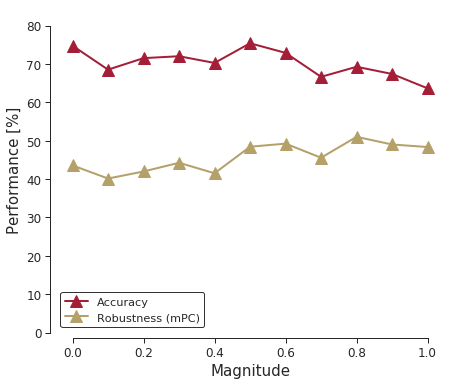

In [14]:
fig = plt.figure(figsize = (7, 6))
ax = plt.subplot(1,1,1)

plt.plot(alphas, [P(r) for r in fixed_alpha_results.values()], 
         '^-',
         label='Accuracy', 
         color=red,
         markersize=markersize, 
         linewidth=linewidth)
plt.plot(alphas, [mPC(r) for r in fixed_alpha_results.values()],
         '^-',
         label='Robustness (mPC)', 
         color=gold,
         markersize=markersize, 
         linewidth=linewidth)
plt.ylim(0, 85)
plt.xlabel('Magnitude', fontsize=fontsize)
plt.ylabel('Performance [%]', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
legend = plt.legend(loc=3, fontsize=legend_fontsize, frameon=True, edgecolor="black")
legend.get_frame().set_linewidth(1.0)

sns.despine(trim=True, offset=5)
plt.show()
fig.savefig('../figures/ResNet18+FM.pdf', bbox_inches='tight')

In [15]:
[mPC(r) for r in fixed_alpha_results_pretrained.values()]

[43.55166666666667,
 43.11333333333334,
 43.473333333333336,
 43.505,
 45.77333333333333,
 48.751666666666665,
 51.33833333333333,
 53.05833333333333,
 55.06166666666667,
 55.33166666666666,
 55.58833333333333]

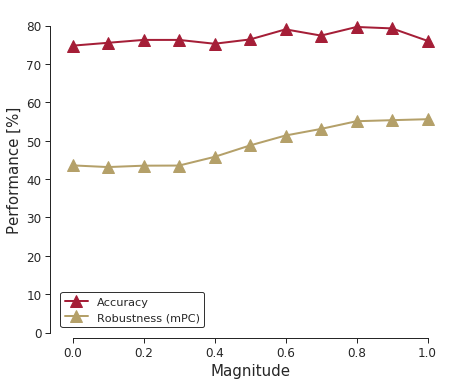

In [16]:
fig = plt.figure(figsize = (7, 6))
ax = plt.subplot(1,1,1)

plt.plot(alphas, [P(r) for r in fixed_alpha_results_pretrained.values()], 
         '^-',
         label='Accuracy', 
         color=red,
         markersize=markersize, 
         linewidth=linewidth)
plt.plot(alphas, [mPC(r) for r in fixed_alpha_results_pretrained.values()],
         '^-',
         label='Robustness (mPC)', 
         color=gold,
         markersize=markersize, 
         linewidth=linewidth)
plt.ylim(0, 85)
plt.xlabel('Magnitude', fontsize=fontsize)
plt.ylabel('Performance [%]', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
legend = plt.legend(loc=3, fontsize=legend_fontsize, frameon=True, edgecolor="black")
legend.get_frame().set_linewidth(1.0)

sns.despine(trim=True, offset=5)

plt.show()
fig.savefig('../figures/ResNet18+FM_pretrained.pdf', bbox_inches='tight')

In [17]:
[mPC(r) for r in fixed_alpha_results_pretrained.values()]

[43.55166666666667,
 43.11333333333334,
 43.473333333333336,
 43.505,
 45.77333333333333,
 48.751666666666665,
 51.33833333333333,
 53.05833333333333,
 55.06166666666667,
 55.33166666666666,
 55.58833333333333]

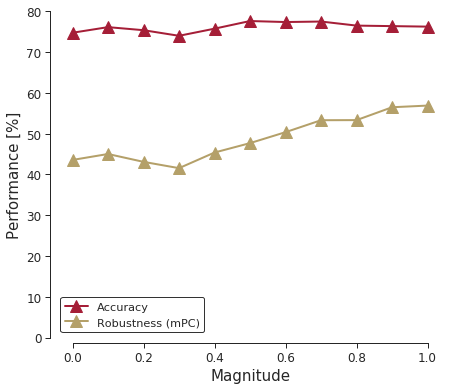

In [18]:
fig = plt.figure(figsize = (7, 6))
ax = plt.subplot(1,1,1)

plt.plot(alphas, [P(r) for r in increasing_alpha_results.values()], 
         '^-',
         label='Accuracy',
         color=red, 
         markersize=markersize, 
         linewidth=linewidth)
plt.plot(alphas, [mPC(r) for r in increasing_alpha_results.values()], 
         '^-',
         label='Robustness (mPC)', 
         color=gold,
         markersize=markersize, 
         linewidth=linewidth)
plt.xlabel('Magnitude', fontsize=fontsize)
plt.ylabel('Performance [%]', fontsize=fontsize)
plt.ylim(0, 80)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
legend = plt.legend(loc=3, fontsize=legend_fontsize, frameon=True, edgecolor="black")
legend.get_frame().set_linewidth(1.0)

sns.despine(trim=True, offset=5)

plt.show()
fig.savefig('../figures/ResNet18+IM.pdf', bbox_inches='tight')

In [19]:
li = []
li.append(pd.read_csv(
    os.path.join(basedir, 
    'gradually_increasing_stylization',
    'stylized',
    'run-ImageNet16_resnet18_gradually_increasing_stylization_stylized_runs_May28_10-58-11_c8ed82731ac1-tag-Losses_train.csv')))
li.append(pd.read_csv(
    os.path.join(basedir, 
    'gradually_increasing_stylization',
    'stylized',
    'run-ImageNet16_resnet18_gradually_increasing_stylization_stylized_runs_May29_11-42-09_c8ed82731ac1-tag-Losses_train.csv')))
IM_train_loss = pd.concat(li)

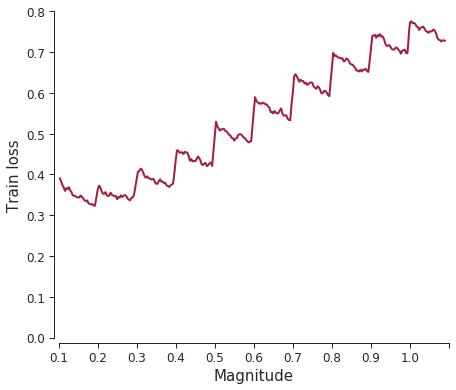

In [20]:
fig = plt.figure(figsize = (7, 6))
ax = plt.subplot(1,1,1)

IM_train_loss.rolling(3).mean().plot('Step', 'Value', ax=ax, color=red, 
         markersize=markersize, 
         linewidth=linewidth,
         legend=None)
plt.xlabel('Magnitude', fontsize=fontsize)
plt.ylabel('Train loss', fontsize=fontsize)
plt.ylim(0, 0.8)
plt.xlim(350, 650)
plt.xticks([350+i*30 for i in range(11)], labels=["{0:1.1f}".format(0.1*(i+1)) for i in range(10)])
ax.tick_params(axis='both', which='major', labelsize=labelsize)

sns.despine(trim=True, offset=5)

plt.show()
fig.savefig('../figures/ResNet18+IM_trainloss.pdf', bbox_inches='tight')

In [21]:
print([mPC(r) for r in fixed_alpha_results.values()])
print([mPC(r) for r in increasing_alpha_results.values()])

[43.55166666666667, 40.126666666666665, 41.961666666666666, 44.23166666666667, 41.5, 48.41166666666667, 49.221666666666664, 45.541666666666664, 50.99333333333333, 48.99666666666667, 48.335]
[43.55166666666667, 45.00833333333333, 43.08166666666666, 41.538333333333334, 45.36833333333333, 47.68, 50.365, 53.29666666666667, 53.321666666666665, 56.47666666666667, 56.88666666666666]


In [22]:
def load_learned(basedir, alpha, from_base=True):
    if from_base:
        path = os.path.join(basedir, 
                            'gradually_increasing_stylization',
                            'alpha_training_on_subset', 
                            'alpha0%d_from_base'%(int(alpha*10)), 
                            'robustness*.pkl')
    else:
        path = os.path.join(basedir, 
                            'gradually_increasing_stylization',
                            'alpha_training_on_subset', 
                            'alpha0%d'%(int(alpha*10)), 
                            'robustness*.pkl')
    path = glob.glob(path)[0]
    return load_result(path)
    

accuracies_from_alpha = {a: load_learned(basedir, a, False) for a in np.arange(0.2, 0.81, 0.2)}
accuracies_from_base = {a: load_learned(basedir, a, True) for a in np.arange(0.2, 0.81, 0.2)}

=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/alpha_training_on_subset/alpha02/robustness_epoch_460.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/alpha_training_on_subset/alpha04/robustness_epoch_520.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/alpha_training_on_subset/alpha06/robustness_epoch_580.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/alpha_training_on_subset/alpha08/robustness_epoch_640.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearning/ImageNet16/resnet18/gradually_increasing_stylization/alpha_training_on_subset/alpha02_from_base/robustness_epoch_400.pkl
=> loaded results from /gpfs01/bethge/home/bmitzkus/scratch/metalearni

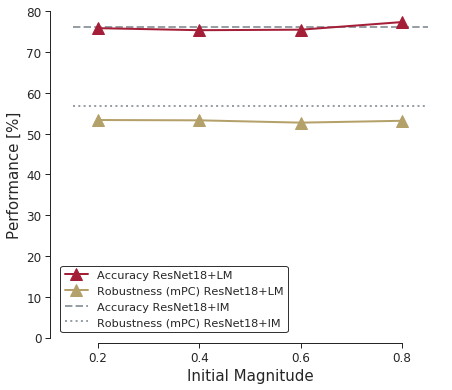

In [23]:
p_from_alpha = [P(acc) for acc in accuracies_from_alpha.values()]
mPC_from_alpha = [mPC(acc) for acc in accuracies_from_alpha.values()]
p_from_base = [P(acc) for acc in accuracies_from_base.values()]
mPC_from_base = [mPC(acc) for acc in accuracies_from_base.values()]

fig = plt.figure(figsize = (7, 6))

ax = plt.subplot(1,1,1)
#plt.plot([0.2, 0.4, 0.6, 0.8], p_from_alpha,
#         '^-', zorder=0, color=red, label='Accuracy (pretrained on stylized)', markersize=markersize,
#          linewidth=linewidth)
#plt.plot([0.2, 0.4, 0.6, 0.8], mPC_from_alpha,
#         's-', zorder=0, color=red, label='mPC (pretrained on stylized)', markersize=markersize,
#          linewidth=linewidth)

plt.plot([0.2, 0.4, 0.6, 0.8], p_from_base,
         '^-', zorder=1, color=red, label='Accuracy ResNet18+LM', markersize=markersize,
          linewidth=linewidth)
plt.plot([0.2, 0.4, 0.6, 0.8], mPC_from_base,
         '^-', zorder=1, color=gold, label='Robustness (mPC) ResNet18+LM', markersize=markersize,
          linewidth=linewidth)
plt.plot([0.15,0.85], [P(increasing_alpha_results[1]) for _ in range(2)],
         '--', zorder=0, color=gray, label='Accuracy ResNet18+IM', markersize=markersize,
          linewidth=linewidth, alpha=0.5)
plt.plot([0.15, 0.85], [mPC(increasing_alpha_results[1]) for _ in range(2)],
         linestyle='dotted', zorder=0, color=gray, label='Robustness (mPC) ResNet18+IM', markersize=markersize,
          linewidth=linewidth, alpha=0.5)
plt.ylim(0, 80)
plt.xticks([0.2, 0.4, 0.6, 0.8])
plt.xlabel('Initial Magnitude', fontsize=fontsize)
plt.ylabel('Performance [%]', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
legend = plt.legend(loc=3, fontsize=legend_fontsize, frameon=True, edgecolor="black")
legend.get_frame().set_linewidth(1.0)

sns.despine(trim=True, offset=5)

plt.show()
fig.savefig('../figures/ResNet18+LM.pdf', bbox_inches='tight')

In [24]:
LM_02_mag = pd.read_csv(
    os.path.join(basedir, 
    'gradually_increasing_stylization',
    'alpha_training_on_subset',
    'run-ImageNet16_resnet18_gradually_increasing_stylization_alpha_training_on_subset_alpha02_runs_Jun03_16-30-42_91074fc4872f_AugNet_means_StyleTransfer-tag-AugNet_means.csv'))
LM_04_mag = pd.read_csv(
    os.path.join(basedir, 
    'gradually_increasing_stylization',
    'alpha_training_on_subset',
    'run-ImageNet16_resnet18_gradually_increasing_stylization_alpha_training_on_subset_alpha04_runs_Jun03_19-18-55_91074fc4872f_AugNet_means_StyleTransfer-tag-AugNet_means.csv'))
LM_06_mag = pd.read_csv(
    os.path.join(basedir, 
    'gradually_increasing_stylization',
    'alpha_training_on_subset',
    'run-ImageNet16_resnet18_gradually_increasing_stylization_alpha_training_on_subset_alpha06_runs_Jun04_00-48-03_91074fc4872f_AugNet_means_StyleTransfer-tag-AugNet_means.csv'))
LM_08_mag = pd.read_csv(
    os.path.join(basedir, 
    'gradually_increasing_stylization',
    'alpha_training_on_subset',
    'run-ImageNet16_resnet18_gradually_increasing_stylization_alpha_training_on_subset_alpha08_runs_Jun04_06-25-04_91074fc4872f_AugNet_means_StyleTransfer-tag-AugNet_means.csv'))

for df in [LM_02_mag, LM_04_mag, LM_06_mag, LM_08_mag]:
    df['Relative'] = df['Step'] - df['Step'][0]

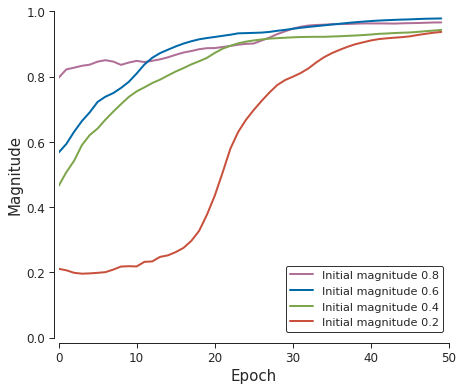

In [25]:
fig = plt.figure(figsize = (7, 6))

ax = plt.subplot(1,1,1)

LM_08_mag.plot('Relative', 'Value', ax=ax, color=purple, 
         markersize=markersize, 
         linewidth=linewidth,
         label='Initial magnitude 0.8')
LM_06_mag.plot('Relative', 'Value', ax=ax, color=blue, 
         markersize=markersize, 
         linewidth=linewidth,
         label='Initial magnitude 0.6')
LM_04_mag.plot('Relative', 'Value', ax=ax, color=green, 
         markersize=markersize, 
         linewidth=linewidth,
         label='Initial magnitude 0.4')
LM_02_mag.plot('Relative', 'Value', ax=ax, color=red2, 
         markersize=markersize, 
         linewidth=linewidth,
         label='Initial magnitude 0.2')

plt.ylim(0, 1)
plt.xlim(0, 50)
plt.xlabel('Epoch', fontsize=fontsize)
plt.ylabel('Magnitude', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
legend = plt.legend(loc=4, fontsize=legend_fontsize, frameon=True, edgecolor="black")
legend.get_frame().set_linewidth(1.0)

sns.despine(trim=True, offset=5)

plt.show()
fig.savefig('../figures/ResNet18+LM_mag.pdf', bbox_inches='tight')

In [26]:
gradients_all = {}

path = os.path.join(basedir, 'gradually_increasing_stylization', 'stylized', 'gradients0.0-1.0.pkl')
with open(path, 'rb') as f:
    gradients_all = pickle.load(f)
    

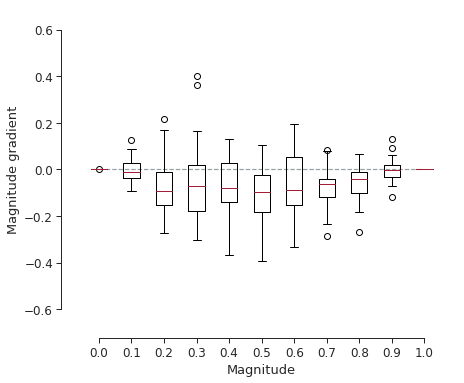

In [27]:
fig = plt.figure(figsize = (7, 6))
alphas = gradients_all.keys()
batchsize=256
#means = [np.median(gradients_all[alpha][batchsize]) for alpha in gradients_all.keys()]
#stds = [np.std(gradients_all[alpha][batchsize]) for alpha in gradients_all.keys()]
#label = 'bs={}'.format(batchsize) if batchsize <= 32 else 'bs={} ({} x 32)'.format(batchsize, batchsize // 32)
#plt.errorbar(x=[alpha for alpha in gradients_all.keys()], y=means, yerr=stds, label=label,
#             markersize=markersize, linewidth=linewidth, color=red)
for alpha in alphas:
    plt.boxplot(x=gradients_all[alpha][batchsize], positions=[alpha], widths=0.05, 
                
                medianprops=dict(color=red))

plt.plot([a for a in alphas], [0 for _ in alphas], zorder=0, color=gray, alpha=0.5, linestyle='--')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.set_ylim([-0.7, 0.7])
ax.set_xlim([-0.1, 1.1])
plt.xticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#legend = plt.legend(loc=3, fontsize=legend_fontsize, frameon=True, edgecolor="black")
#legend.get_frame().set_linewidth(1.0)

plt.xlabel('Magnitude', fontsize=fontsize-2)
plt.ylabel('Magnitude gradient', fontsize=fontsize-2)


sns.despine(trim=True, offset=5)
plt.show()
fig.savefig('../figures/ResNet18+IM_grad.pdf', bbox_inches='tight')

In [40]:
individual_magnitudes = pd.DataFrame.from_dict(summaries, orient='index', columns=['index', 'step', 'value'])
individual_magnitudes.step -= individual_magnitudes.step.min()
print(individual_magnitudes.describe())
np.random.seed(131313)
indices_subset = np.random.choice(indices, 20, replace=False)
print(sorted(indices_subset))

              index          step         value
count  25600.000000  25600.000000  25600.000000
mean      63.500000     99.500000      0.370741
std       36.950011     57.735433      0.313500
min        0.000000      0.000000      0.011516
25%       31.750000     49.750000      0.106659
50%       63.500000     99.500000      0.247733
75%       95.250000    149.250000      0.647367
max      127.000000    199.000000      0.984770
[5, 7, 29, 33, 36, 61, 62, 63, 72, 88, 89, 91, 92, 94, 95, 108, 110, 111, 112, 126]


In [41]:
individual_magnitudes_at_finish = individual_magnitudes[individual_magnitudes['step'] == 199]
print('Mag < .25: {0}, .25 <= Mag < .75: {1}, .75 <= Mag: {2}'.format(
    individual_magnitudes_at_finish[individual_magnitudes_at_finish['value'] < 0.25].count()['index'],
    (individual_magnitudes_at_finish[individual_magnitudes_at_finish['value'] < 0.75].count() - individual_magnitudes_at_finish[individual_magnitudes_at_finish['value'] < 0.25].count())['index'],
    individual_magnitudes_at_finish[individual_magnitudes_at_finish['value'] > 0.75].count()['index']
))

Mag < .25: 72, .25 <= Mag < .75: 21, .75 <= Mag: 35


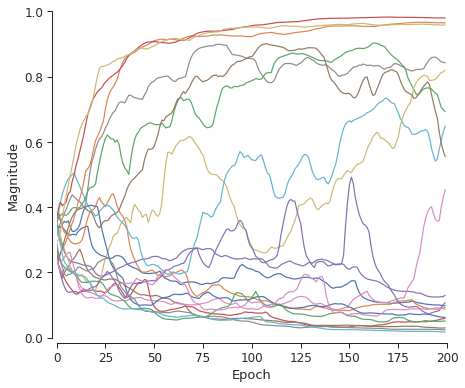

In [42]:
fig = plt.figure(figsize = (7, 6))
ax = plt.gca()
for name, group in individual_magnitudes.groupby('index'):
    if name in indices_subset:
        group.plot('step', 'value', ax=ax, label=name, legend=None)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.set_ylim([0, 1])
ax.set_xlim([0, 200])
#legend = plt.legend(loc=9, fontsize=legend_fontsize, frameon=True, edgecolor="black")
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#legend.get_frame().set_linewidth(1.0)

plt.xlabel('Epoch', fontsize=fontsize-2)
plt.ylabel('Magnitude', fontsize=fontsize-2)


sns.despine(trim=True, offset=5)
plt.show()
fig.savefig('../figures/individual_magnitudes_over_training.pdf', bbox_inches='tight')

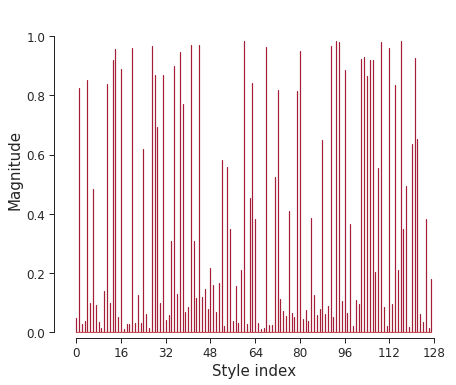

In [43]:
fig = plt.figure(figsize = (7, 6))

ax = plt.subplot(1,1,1)
markerline, stemlines, baseline = plt.stem(indices, individual_magnitudes_at_finish.value, markerfmt=' ', label='Learned probabilities')
plt.setp(stemlines, 'color', red)

plt.ylim([-1e-6, 1.1])
plt.xticks([i*16 for i in range(9)])

plt.ylabel('Magnitude', fontsize=fontsize)
plt.xlabel('Style index', fontsize=fontsize)

ax.tick_params(axis='both', which='major', labelsize=labelsize)
sns.despine(trim=True, offset=5)


plt.show()
fig.savefig('../figures/individual_magnitudes.pdf', bbox_inches='tight')

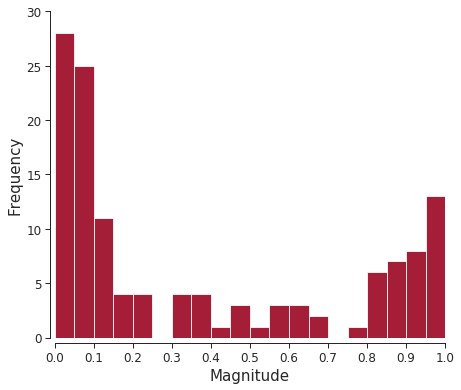

In [130]:
fig = plt.figure(figsize = (7, 6))

ax = plt.subplot(1,1,1)
#markerline, stemlines, baseline = plt.stem(indices, individual_magnitudes_at_finish.value, markerfmt=' ', label='Learned probabilities')

plt.hist(individual_magnitudes_at_finish.value, color=red, bins=[0.05*i for i in range(21)])

plt.ylabel('Frequency', fontsize=fontsize)
plt.xlabel('Magnitude', fontsize=fontsize)

plt.ylim([0, 30])
plt.xlim([0, 1])

plt.xticks([0.1*i for i in range(11)])

ax.tick_params(axis='both', which='major', labelsize=labelsize)
sns.despine(trim=True, offset=5)


plt.show()
fig.savefig('../figures/individual_magnitudes_histogram.pdf', bbox_inches='tight')

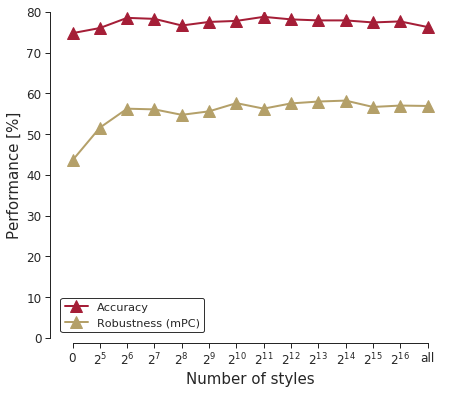

In [44]:
fig = plt.figure(figsize = (7, 6))

ax = plt.subplot(1,1,1)
plt.plot(np.arange(len(num_styles)), p_style_subsets,
         '^-', zorder=0, color=red, label='Accuracy', markersize=markersize,
          linewidth=linewidth)
plt.plot(np.arange(len(num_styles)), mpc_style_subsets,
         '^-', zorder=0, color=gold, label='Robustness (mPC)', markersize=markersize,
          linewidth=linewidth)
plt.ylim(0, 80)
plt.xlabel('Number of styles', fontsize=fontsize)
plt.ylabel('Performance [%]', fontsize=fontsize)
ticks = [r'$2^{%d}$' % (n) for n in np.arange(5, 17)]
ticks.insert(0, r'$0$')
ticks.append('all')
plt.xticks(np.arange(len(ticks)), ticks)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
legend = plt.legend(loc=3, fontsize=legend_fontsize, frameon=True, edgecolor="black")
legend.get_frame().set_linewidth(1.0)

sns.despine(trim=True, offset=5)

plt.show()
fig.savefig('../figures/StyleSubset.pdf', bbox_inches='tight')

In [45]:
print('Dummy: p=%2.2f, mPC=%2.2f'%(P(dummy_accuracies), mPC(dummy_accuracies)))
print('64 style subset: p=%2.2f, mPC=%2.2f'%(p_style_subsets[2], mpc_style_subsets[2]))
print('Dist learning: p=%2.2f, mPC=%2.2f'%(P(style_dist_accuracies), mPC(style_dist_accuracies)))
print('128 style subset: p=%2.2f, mPC=%2.2f'%(p_style_subsets[3], mpc_style_subsets[3]))


Dummy: p=79.88, mPC=55.01
64 style subset: p=78.50, mPC=56.22
Dist learning: p=78.38, mPC=55.18
128 style subset: p=78.25, mPC=56.05


In [46]:
dummy_logits = dummy['augmodel_state_dict']['augmentations.1.logits']
style_dist_logits = style_dist['augmodel_state_dict']['augmentations.1.logits']
dummy_probs = torch.nn.functional.softmax(dummy_logits)
style_dist_probs = torch.nn.functional.softmax(style_dist_logits)

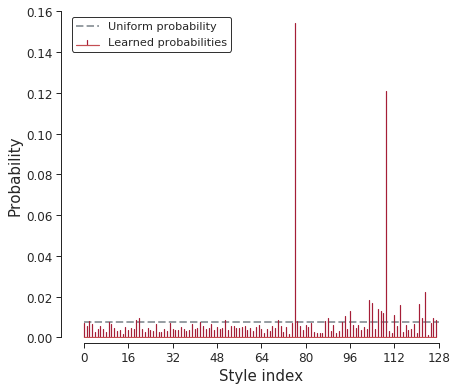

In [47]:
fig = plt.figure(figsize = (7, 6))

ax = plt.subplot(1,1,1)

markerline, stemlines, baseline = plt.stem(np.arange(128), dummy_probs, markerfmt=' ', label='Learned probabilities')
plt.setp(stemlines, 'color', red)
plt.plot([0, 128], [1/128 for _ in range(2)], zorder=0, color=gray, label='Uniform probability', markersize=markersize,
          linewidth=linewidth, alpha=0.5, linestyle='--')

plt.ylim([-1e-6, 0.16])
plt.xticks([i*16 for i in range(9)])

plt.ylabel('Probability', fontsize=fontsize)
plt.xlabel('Style index', fontsize=fontsize)

legend = plt.legend(loc=2, fontsize=legend_fontsize, frameon=True, edgecolor="black")
legend.get_frame().set_linewidth(1.0)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
sns.despine(trim=True, offset=5)


plt.show()
fig.savefig('../figures/style_dist_dummy.pdf', bbox_inches='tight')

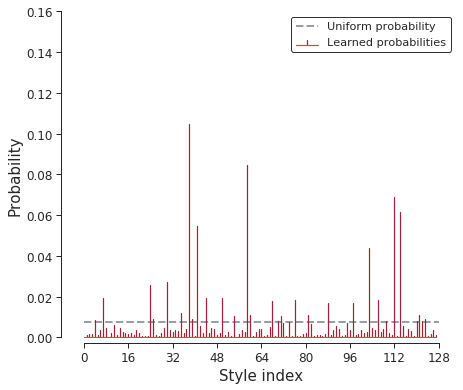

In [48]:
fig = plt.figure(figsize = (7, 6))

ax = plt.subplot(1,1,1)

markerline, stemlines, baseline = plt.stem(np.arange(128), style_dist_probs, markerfmt=' ', label='Learned probabilities')
plt.setp(stemlines, 'color', red)
plt.ylim(-1e-6, 0.16)
plt.xticks([i*16 for i in range(9)])
plt.plot([0, 128], [1/128 for _ in range(2)], zorder=0, color=gray, label='Uniform probability', markersize=markersize,
          linewidth=linewidth, alpha=0.5, linestyle='--')

plt.ylabel('Probability', fontsize=fontsize)
plt.xlabel('Style index', fontsize=fontsize)

legend = plt.legend(loc=1, fontsize=legend_fontsize, frameon=True, edgecolor="black")
legend.get_frame().set_linewidth(1.0)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
sns.despine(trim=True, offset=5)

plt.show()
fig.savefig('../figures/style_dist.pdf', bbox_inches='tight')

In [166]:
sorted_dist, indices = torch.sort(style_dist_probs, descending=True)
indices[6:]

tensor([ 30,  24,  50,   7,  44, 106,  76,  68,  88,  97,  35, 121,  60,  81,
         71,  54,  25,  39, 123,   4, 120, 122,  70, 109,  74,  72,  95,  82,
         11,  91,  42, 115,  67, 104,   8,  29,  46,  13, 108,  47, 117,  37,
         63,  92,  64,  90, 105, 100,   6,  19,  33,  57,  31,  96, 126, 118,
         34, 102,  32,  62,  58, 107,  14,  52,  43,  49,  20,  80,  10,  17,
         28, 101,  36,  15,  45, 110,  16, 125,   3,  99,  79,  56,  87,   2,
         98,   5,  84,  51,  48,  18,  12,   1, 127,  66,  94, 111,  26,  89,
         85,  53,  73,  77,  21,  22, 116,  40,  65,  86,  93,  27,  75,  61,
        119, 113,  69,  23,  78,  83, 124,   0,  55,   9])

In [190]:
# exclude outliers
X = individual_magnitudes[individual_magnitudes.step == 199].value.values[indices.numpy()[6:]].reshape(-1, 1)
y = style_dist_probs[indices[6:]]

reg = LinearRegression()
reg.fit(X, y)
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_, reg.coef_[0]))

The linear model is: Y = 0.003574 + 0.0033809X


In [186]:
X = individual_magnitudes[individual_magnitudes.step == 199].value.values[indices.numpy()[6:]].reshape(-1, 1)
y = style_dist_probs[indices[6:]].numpy()
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6.508
Date:                Wed, 29 Jul 2020   Prob (F-statistic):             0.0120
Time:                        14:03:16   Log-Likelihood:                 467.35
No. Observations:                 122   AIC:                            -930.7
Df Residuals:                     120   BIC:                            -925.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      5.350      0.0

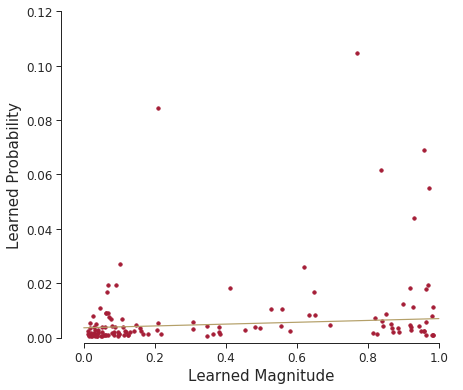

Correlation between magnitude and probability: 0.272


In [191]:
fig = plt.figure(figsize = (7, 6))

ax = plt.subplot(1,1,1)

plt.scatter(individual_magnitudes[individual_magnitudes.step == 199].value, style_dist_probs, color=red, s=markersize)
plt.plot([0, 1], [reg.intercept_, reg.intercept_+reg.coef_[0]], color=gold)

plt.ylabel('Learned Probability', fontsize=fontsize)
plt.xlabel('Learned Magnitude', fontsize=fontsize)


plt.ylim([0, 0.12])
#legend = plt.legend(loc=1, fontsize=legend_fontsize, frameon=True, edgecolor="black")
#legend.get_frame().set_linewidth(1.0)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
sns.despine(trim=True, offset=5)

plt.show()
fig.savefig('../figures/correlation_magnitude_probability.pdf', bbox_inches='tight')
print("Correlation between magnitude and probability: {0:1.3f}".format(np.corrcoef(np.array(individual_magnitudes[individual_magnitudes.step == 199].value), style_dist_probs)[0][1]))

In [50]:
from augmentations import AdaptiveStyleTransfer
ast = AdaptiveStyleTransfer()
seed = 131213
ast.initStyles(128, seed=seed)
rng_state = torch.get_rng_state()
torch.manual_seed(seed)
pbn_split, _ = torch.utils.data.dataset.random_split(ast._PainterByNumbers, [128, len(ast._PainterByNumbers) - 128])
torch.set_rng_state(rng_state)
sorted_dist, indices = torch.sort(style_dist_probs, descending=True)

=> Preloading Styles
=> Precomputing style features
=> Style Transfer initialized


In [51]:
print('Style indices used for 8style distilled training: ' + str(sorted(indices.numpy()[:8])))
print('Style indices used for 16style distilled training: ' + str(sorted(indices.numpy()[:16])))
print('Style indices used for 32style distilled training: ' + str(sorted(indices.numpy()[:32])))

Style indices used for 8style distilled training: [24, 30, 38, 41, 59, 103, 112, 114]
Style indices used for 16style distilled training: [7, 24, 30, 38, 41, 44, 50, 59, 68, 76, 88, 97, 103, 106, 112, 114]
Style indices used for 32style distilled training: [4, 7, 24, 25, 30, 35, 38, 39, 41, 44, 50, 54, 59, 60, 68, 70, 71, 72, 74, 76, 81, 88, 97, 103, 106, 109, 112, 114, 120, 121, 122, 123]


In [89]:
n = 10
best_styles = indices[:n]
worst_styles = indices[-n:]
torch.random.manual_seed(42)
random_styles = indices[torch.randperm(indices.size()[0])[:n]]

In [110]:
_, sorted_random_indices = torch.sort(style_dist_probs[random_styles], descending=True)
sorted_random_styles = random_styles[sorted_random_indices]
print(random_styles, sorted_random_styles)
print(style_dist_probs[random_styles], style_dist_probs[sorted_random_styles])

tensor([26, 14, 98, 46, 73, 35, 34, 60, 36, 74]) tensor([35, 60, 74, 46, 34, 14, 36, 98, 26, 73])
tensor([0.0010, 0.0026, 0.0015, 0.0045, 0.0010, 0.0122, 0.0032, 0.0111, 0.0021,
        0.0074]) tensor([0.0122, 0.0111, 0.0074, 0.0045, 0.0032, 0.0026, 0.0021, 0.0015, 0.0010,
        0.0010])


In [111]:
print('Best styles:')
for best in best_styles:
    print(pbn_split.dataset.samples[pbn_split.indices[best]])
print('Worst styles:')
for worst in worst_styles:
    print(pbn_split.dataset.samples[pbn_split.indices[worst]])
print('Random styes:')
for random in sorted_random_styles:
    print(pbn_split.dataset.samples[pbn_split.indices[random]])

Best styles:
/gpfs01/bethge/data/painter_by_numbers/train/7315.jpg
/gpfs01/bethge/data/painter_by_numbers/train/63031.jpg
/gpfs01/bethge/data/painter_by_numbers/train/23217.jpg
/gpfs01/bethge/data/painter_by_numbers/train/44458.jpg
/gpfs01/bethge/data/painter_by_numbers/train/61150.jpg
/gpfs01/bethge/data/painter_by_numbers/train/16026.jpg
/gpfs01/bethge/data/painter_by_numbers/train/40151.jpg
/gpfs01/bethge/data/painter_by_numbers/train/49464.jpg
/gpfs01/bethge/data/painter_by_numbers/train/88626.jpg
/gpfs01/bethge/data/painter_by_numbers/train/9041.jpg
Worst styles:
/gpfs01/bethge/data/painter_by_numbers/train/53374.jpg
/gpfs01/bethge/data/painter_by_numbers/train/71435.jpg
/gpfs01/bethge/data/painter_by_numbers/train/91168.jpg
/gpfs01/bethge/data/painter_by_numbers/train/49985.jpg
/gpfs01/bethge/data/painter_by_numbers/train/53349.jpg
/gpfs01/bethge/data/painter_by_numbers/train/18881.jpg
/gpfs01/bethge/data/painter_by_numbers/train/92416.jpg
/gpfs01/bethge/data/painter_by_numbers/t

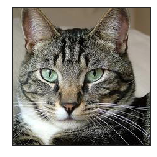

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

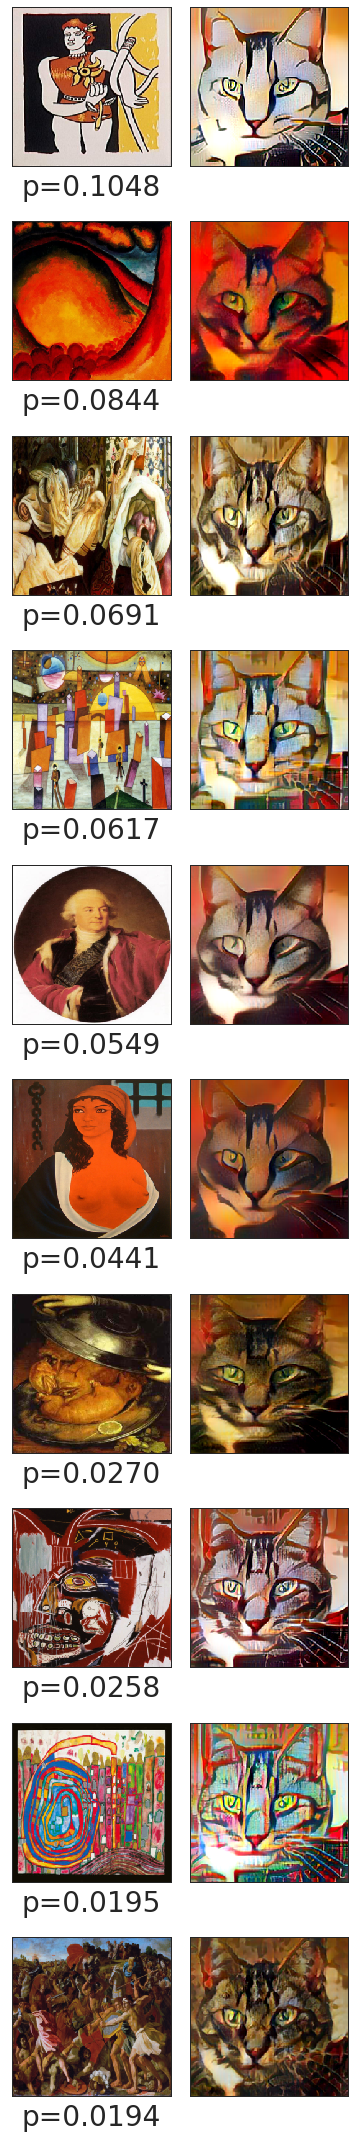

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


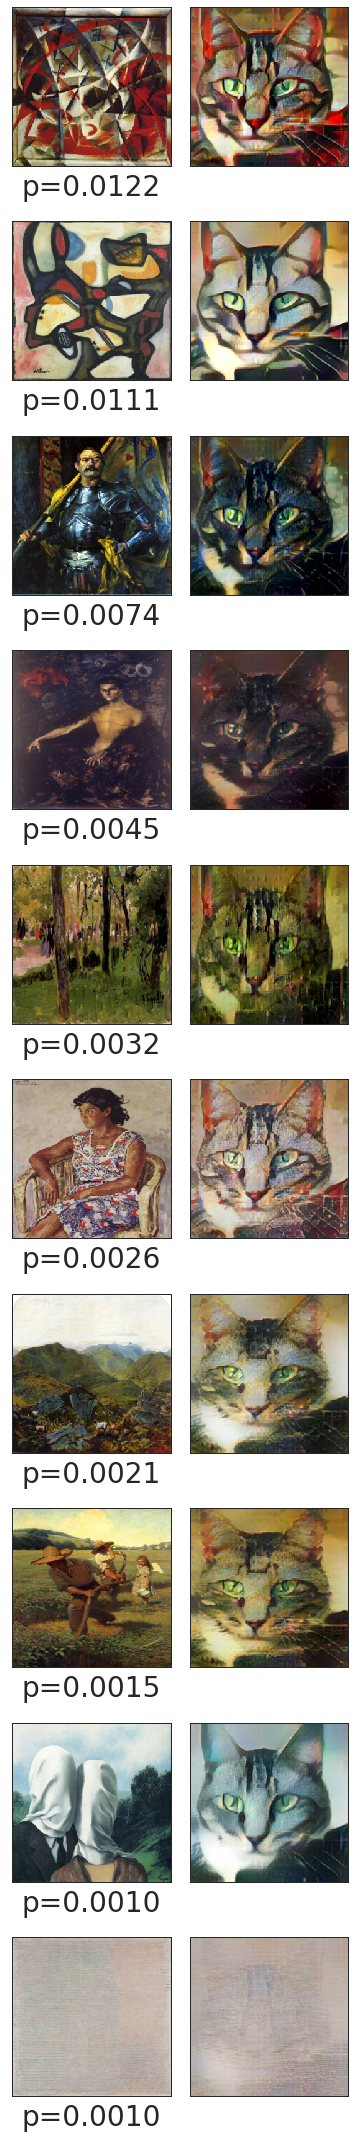

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


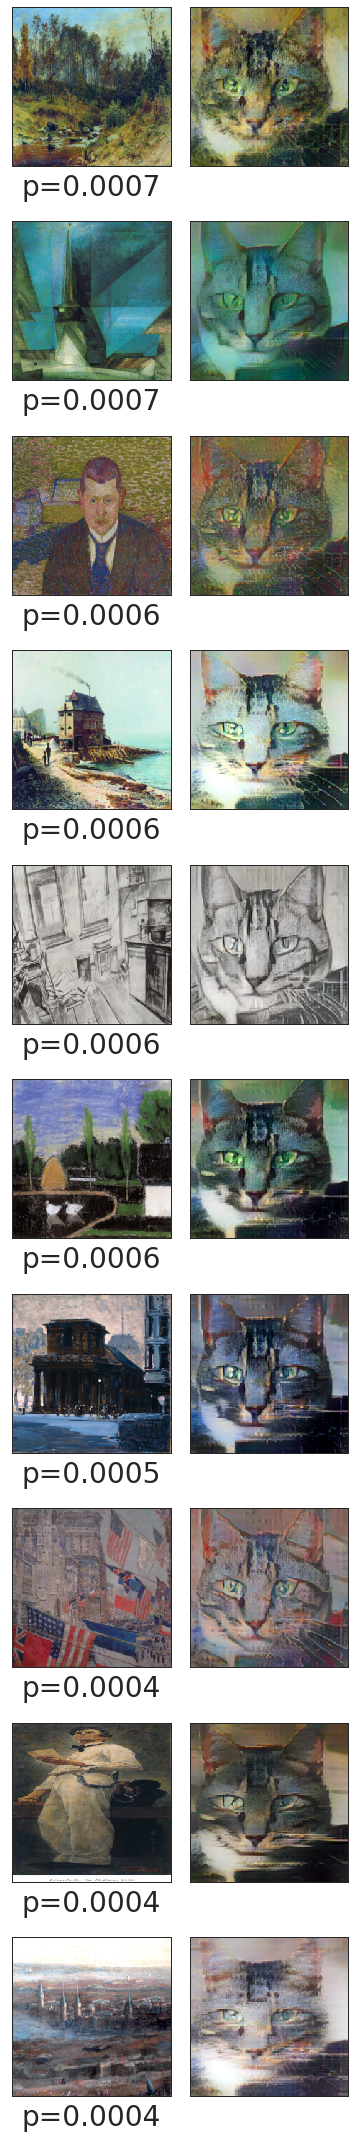

In [283]:
content = Image.open('/gpfs01/bethge/data/sixteen-class-imagenet-balanced-trainval/train/11_cat/n02123045_1991.JPEG')
T = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
S = transforms.Compose([transforms.Resize([256, 256]), transforms.ToTensor()])
toPil = lambda x: x.numpy().squeeze().transpose([1,2,0])
content_tensor = T(content)
content = toPil(T(content))
fig = plt.figure(figsize=(5, 3*n))
plt.subplot(n, 1, 3)
plt.imshow(content)
plt.xticks([])
plt.yticks([])
plt.show()
fig.savefig('../figures/style_dist_preview_0.pdf', bbox_inches='tight')
fig = plt.figure(figsize=(5, 3*n))
for i, style in enumerate(best_styles):
    plt.subplot(n, 2, 1+(i*2))
    plt.xticks([])
    plt.yticks([])
    s = Image.open(pbn_split.dataset.samples[pbn_split.indices[style]])
    plt.imshow(toPil(S(s)))
    plt.title('p={0:0.4f}'.format(np.round(style_dist_probs[style], 4)), y=-0.225, fontsize=28)
    with torch.no_grad():
        stylized = ast._transform(content_tensor.unsqueeze(0), (torch.tensor(1.), ast.style_features[style].unsqueeze(0)))
    plt.subplot(n, 2, 2+(i*2))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(toPil(stylized.squeeze()))
plt.tight_layout(h_pad=1, w_pad=1)

plt.show()
fig.savefig('../figures/style_dist_preview_1.pdf', bbox_inches='tight')
fig = plt.figure(figsize=(5, 3*n))
for i, style in enumerate(sorted_random_styles):
    plt.subplot(n, 2, 1+(i*2))
    plt.xticks([])
    plt.yticks([])
    s = Image.open(pbn_split.dataset.samples[pbn_split.indices[style]])
    plt.imshow(toPil(S(s)))
    plt.title('p={0:0.4f}'.format(np.round(style_dist_probs[style], 4)), y=-0.225, fontsize=28)
    with torch.no_grad():
        stylized = ast._transform(content_tensor.unsqueeze(0), (torch.tensor(1.), ast.style_features[style].unsqueeze(0)))
    plt.subplot(n, 2, 2+(i*2))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(toPil(stylized.squeeze()))
plt.tight_layout(h_pad=1, w_pad=1)

plt.show()
fig.savefig('../figures/style_dist_preview_2.pdf', bbox_inches='tight')
fig = plt.figure(figsize=(5, 3*n))
for i, style in enumerate(worst_styles):
    ax = plt.subplot(n, 2, 1+(i*2))
    plt.xticks([])
    plt.yticks([])
    s = Image.open(pbn_split.dataset.samples[pbn_split.indices[style]])
    plt.imshow(toPil(S(s)))
    plt.title('p={0:0.4f}'.format(np.round(style_dist_probs[style], 4)), y=-0.225, fontsize=28)
    with torch.no_grad():
        stylized = ast._transform(content_tensor.unsqueeze(0), (torch.tensor(1.), ast.style_features[style].unsqueeze(0)))
    ax = plt.subplot(n, 2, 2+(i*2))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(toPil(stylized.squeeze()))
plt.tight_layout(h_pad=1, w_pad=1)
    
plt.show()
fig.savefig('../figures/style_dist_preview_3.pdf', bbox_inches='tight')

In [106]:
for r in [accuracies_style_subsets[0], distilled_results_8, distilled_results_16, distilled_results_32, accuracies_style_subsets[1], accuracies_style_subsets[2]]:
    print(P(r), mPC(r))

74.75 43.55166666666667
74.875 47.99
75.75 49.223333333333336
77.125 52.276666666666664
76.0 51.555
78.5 56.221666666666664


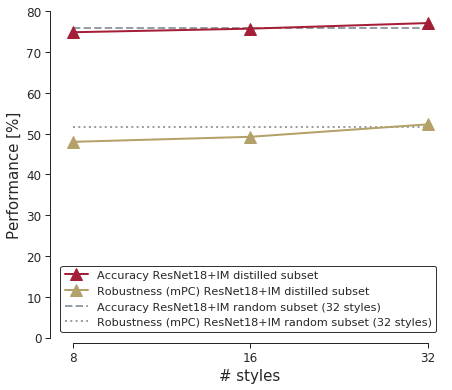

In [131]:
p_distilled = [P(distilled_results_8), P(distilled_results_16), P(distilled_results_32)]
mpc_distilled = [mPC(distilled_results_8), mPC(distilled_results_16), mPC(distilled_results_32)]

fig = plt.figure(figsize = (7, 6))

ax = plt.subplot(1,1,1)
#plt.plot([0.2, 0.4, 0.6, 0.8], p_from_alpha,
#         '^-', zorder=0, color=red, label='Accuracy (pretrained on stylized)', markersize=markersize,
#          linewidth=linewidth)
#plt.plot([0.2, 0.4, 0.6, 0.8], mPC_from_alpha,
#         's-', zorder=0, color=red, label='mPC (pretrained on stylized)', markersize=markersize,
#          linewidth=linewidth)

plt.plot([0, 1, 2], p_distilled,
         '^-', zorder=1, color=red, label='Accuracy ResNet18+IM distilled subset', markersize=markersize,
          linewidth=linewidth)
plt.plot([0, 1, 2], mpc_distilled,
         '^-', zorder=1, color=gold, label='Robustness (mPC) ResNet18+IM distilled subset', markersize=markersize,
          linewidth=linewidth)
plt.plot([0, 2], [p_style_subsets[1] for _ in range(2)],
         '--', zorder=0, color=gray, label='Accuracy ResNet18+IM random subset (32 styles)', markersize=markersize,
          linewidth=linewidth, alpha=0.5)
plt.plot([0, 2], [mpc_style_subsets[1] for _ in range(2)],
         linestyle='dotted', zorder=0, color=gray, label='Robustness (mPC) ResNet18+IM random subset (32 styles)', markersize=markersize,
          linewidth=linewidth, alpha=0.5)

plt.ylim(0, 80)
plt.xticks([0,1,2], labels=[8, 16, 32])
plt.xlabel('# styles', fontsize=fontsize)
plt.ylabel('Performance [%]', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
legend = plt.legend(loc=3, fontsize=legend_fontsize, frameon=True, edgecolor="black")
legend.get_frame().set_linewidth(1.0)

sns.despine(trim=True, offset=5)

plt.show()
fig.savefig('../figures/ResNet18+IM_distilled.pdf', bbox_inches='tight')

In [381]:
print(mpc_style_subsets[1])
print(mpc_distilled[-1])

51.555
52.276666666666664


In [95]:
for m, r in increasing_alpha_results.items():
    print("Mag={0:1.1f}, P={1:1.3f}, mPC={2:1.3f}".format(m, P(r), mPC(r)))

Mag=0.0, P=74.750, mPC=43.552
Mag=0.1, P=76.125, mPC=45.008
Mag=0.2, P=75.375, mPC=43.082
Mag=0.3, P=74.000, mPC=41.538
Mag=0.4, P=75.750, mPC=45.368
Mag=0.5, P=77.625, mPC=47.680
Mag=0.6, P=77.375, mPC=50.365
Mag=0.7, P=77.500, mPC=53.297
Mag=0.8, P=76.500, mPC=53.322
Mag=0.9, P=76.375, mPC=56.477
Mag=1.0, P=76.250, mPC=56.887


In [96]:
rn50in_sin_CE = {
    'gaussian_noise': 66.2, 
    'shot_noise': 66.8, 
    'impulse_noise': 68.1, 
    'defocus_blur': 69.6, 
    'glass_blur': 81.9, 
    'motion_blur': 69.4, 
    'zoom_blur': 80.5, 
    'snow': 68.0, 
    'frost': 70.6, 
    'fog': 64.7, 
    'brightness': 57.8, 
    'contrast': 66.4, 
    'elastic_transform': 78.2, 
    'pixelate': 61.9, 
    'jpeg_compression': 69.7
}
rn50in_sin_p = 76.72
rn50in_sin_mce = 69.3

print('ResNet50          : P={0:2.2f}, mPC={1:2.2f}, mCE={2:2.2f}'.format(P(imagenet_baseline_results), mPC(imagenet_baseline_results), mCE(imagenet_baseline_results)))
print('ResNet50+IM@lr1e-1: P={0:2.2f}, mPC={1:2.2f}, mCE={2:2.2f}'.format(P(imagenet_lr1e1_results), mPC(imagenet_lr1e1_results), mCE(imagenet_lr1e1_results)))
print('ResNet50+IM@lr1e-2: P={0:2.2f}, mPC={1:2.2f}, mCE={2:2.2f}'.format(P(imagenet_lr1e2_results), mPC(imagenet_lr1e2_results), mCE(imagenet_lr1e2_results)))
print('ResNet50+IM@lr1e-3: P={0:2.2f}, mPC={1:2.2f}, mCE={2:2.2f}'.format(P(imagenet_lr1e3_results), mPC(imagenet_lr1e3_results), mCE(imagenet_lr1e3_results)))
print('ResNet50 IN+SIN   : P={0:2.2f}, mPC={1:2.2f}, mCE={2:2.2f}'.format(rn50in_sin_p, mCE_to_mPC(rn50in_sin_CE), rn50in_sin_mce))

ResNet50          : P=76.13, mPC=39.17, mCE=76.70
ResNet50+IM@lr1e-1: P=71.31, mPC=40.62, mCE=74.85
ResNet50+IM@lr1e-2: P=72.82, mPC=41.60, mCE=73.49
ResNet50+IM@lr1e-3: P=73.29, mPC=43.72, mCE=70.91
ResNet50 IN+SIN   : P=76.72, mPC=45.22, mCE=69.30


In [97]:
print("Clean error: {0:2.2f}".format(100 - imagenet_lr1e1_results['gaussian_noise'][0]))
for c, v in imagenet_lr1e3_results.items():
    vals = []
    for s, val in v.items():
        if s==0:
            continue
        vals.append(np.round((100-val)/100, 5))
    s = c + ": Average("
    s += str(vals)[1:-1]
    s += ")"
    print(s)

Clean error: 28.69
gaussian_noise: Average(0.43428, 0.54016, 0.69554, 0.84754, 0.95784)
shot_noise: Average(0.45698, 0.57524, 0.7115, 0.87674, 0.94294)
impulse_noise: Average(0.50328, 0.62144, 0.71126, 0.8641, 0.95752)
defocus_blur: Average(0.4038, 0.47368, 0.60648, 0.71562, 0.8009)
glass_blur: Average(0.42858, 0.52864, 0.72308, 0.76996, 0.83162)
motion_blur: Average(0.36786, 0.44632, 0.56112, 0.6838, 0.76226)
zoom_blur: Average(0.4972, 0.58118, 0.62332, 0.69332, 0.7534)
snow: Average(0.42414, 0.60394, 0.575, 0.67192, 0.72438)
frost: Average(0.37722, 0.5013, 0.59012, 0.6049, 0.65968)
fog: Average(0.35232, 0.38722, 0.4383, 0.47382, 0.59148)
brightness: Average(0.27886, 0.29284, 0.31434, 0.34504, 0.38772)
contrast: Average(0.33408, 0.37792, 0.46674, 0.70344, 0.9214)
elastic_transform: Average(0.35332, 0.55412, 0.34904, 0.4141, 0.62916)
pixelate: Average(0.33944, 0.34182, 0.44564, 0.55548, 0.6225)
jpeg_compression: Average(0.3463, 0.37956, 0.40864, 0.49704, 0.6247)


In [98]:
print('ResNet18: P={0:2.2f}, mPC={1:2.2f}'.format(P(baseline_results), mPC(baseline_results)))
maxidx = np.argmax([mPC(r) for r in fixed_alpha_results_pretrained.values()])
maxkey = list(fixed_alpha_results_pretrained.keys())[maxidx]
print('ResNet18+FM@mag{2:1.1f}: P={0:2.2f}, mPC={1:2.2f}'.format(P(fixed_alpha_results_pretrained[maxkey]), mPC(fixed_alpha_results_pretrained[maxkey]), maxkey))
maxidx = np.argmax([mPC(r) for r in increasing_alpha_results.values()])
maxkey = list(increasing_alpha_results.keys())[maxidx]
print('ResNet18+IM@mag{2:1.1f}: P={0:2.2f}, mPC={1:2.2f}'.format(P(increasing_alpha_results[maxkey]), mPC(increasing_alpha_results[maxkey]), maxkey))
maxidx = np.argmax(mPC_from_base)
maxkey = [0.2*i for i in range(1,5)][maxidx]
print('ResNet18+LM (initial mag{2:1.1f}): P={0:2.2f}, mPC={1:2.2f}'.format(p_from_base[maxidx], mPC_from_base[maxidx], maxkey))
print('ResNet18+LM (individual magnitudes): P={0:2.2f}, mPC={1:2.2f}'.format(P(individual_alpha_results), mPC(individual_alpha_results)))
distilled = [distilled_results_8, distilled_results_16, distilled_results_32]
p_distilled = [P(r) for r in distilled]
mpc_distilled = [mPC(r) for r in distilled]
maxidx = np.argmax(mpc_distilled)
maxkey = [8, 16, 32][maxidx]
print('ResNet18+IM (distilled {2} styles): P={0:2.2f}, mPC={1:2.2f}'.format(p_distilled[maxidx], mpc_distilled[maxidx], maxkey))
print()
print('ResNet50: P={0:2.2f}, mPC={1:2.2f}, mCE={2:2.2f}'.format(P(imagenet_baseline_results), mPC(imagenet_baseline_results), mCE(imagenet_baseline_results)))
IN_IM = [imagenet_lr1e1_results, imagenet_lr1e2_results, imagenet_lr1e3_results]
p_IN_IM = [P(r) for r in IN_IM]
mpc_IN_IM = [mPC(r) for r in IN_IM]
mce_IN_IM = [mCE(r) for r in IN_IM]
maxidx = np.argmax(mpc_IN_IM)
print('ResNet50+IM: P={0:2.2f}, mPC={1:2.2f}, mCE={2:2.2f}'.format(p_IN_IM[maxidx], mpc_IN_IM[maxidx], mce_IN_IM[maxidx]))
print('ResNet50 IN+SIN: P={0:2.2f}, mPC={1:2.2f}, mCE={2:2.2f}'.format(rn50in_sin_p, mCE_to_mPC(rn50in_sin_CE), rn50in_sin_mce))

ResNet18: P=74.75, mPC=43.55
ResNet18+FM@mag1.0: P=76.00, mPC=55.59
ResNet18+IM@mag1.0: P=76.25, mPC=56.89
ResNet18+LM (initial mag0.2): P=75.88, mPC=53.34
ResNet18+LM (individual magnitudes): P=78.38, mPC=49.86
ResNet18+IM (distilled 32 styles): P=77.12, mPC=52.28

ResNet50: P=76.13, mPC=39.17, mCE=76.70
ResNet50+IM: P=73.29, mPC=43.72, mCE=70.91
ResNet50 IN+SIN: P=76.72, mPC=45.22, mCE=69.30


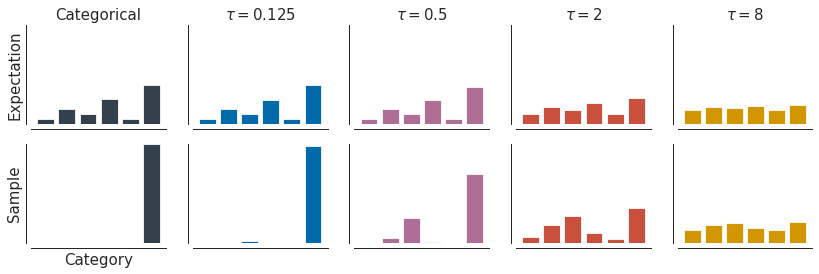

In [317]:
from utils import GumbelSoftmax
logits = torch.log(torch.tensor([0.05, 0.15, 0.1, 0.25, 0.05, 0.4]))
taus = [0, 0.125, 0.5, 2, 8]
colors = [gray, blue, purple, red2, yellow]

fig = plt.figure(figsize = (14, 4))
for i, (tau, c) in enumerate(zip(taus, colors)):
    dist = GumbelSoftmax(temperature=tau, logits=logits)
    torch.random.manual_seed(13)
    if tau == 0:
        s = [0, 0, 0, 0, 0, 1]
        expect = torch.exp(logits)
    else:
        sample = dist.rsample(torch.Size([100000]))
        s = sample[0]
        expect = sample.mean(axis=0)
    plt.subplot(2, len(taus), 1+i)
    plt.bar(np.arange(6), expect, color=c)
    
    plt.xticks([])
    plt.yticks([])
    plt.ylim([0, 1])
    sns.despine(trim=True, offset=5)
    if tau == 0:
        plt.ylabel('Expectation', fontsize=fontsize)
        plt.title('Categorical', fontsize=fontsize)
    else:
        plt.title(r'$\tau={}$'.format(tau), fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.subplot(2, len(taus), 1+i+len(taus))
    plt.bar(np.arange(6), s, color=c)
    plt.xticks([])
    plt.yticks([])
    plt.ylim([0, 1])
    if tau == 0:
        plt.xlabel('Category', fontsize=fontsize)
        plt.ylabel('Sample', fontsize=fontsize)
    sns.despine(trim=True, offset=5)
plt.show()
fig.savefig('../figures/GumbelSoftmax_preview.pdf', bbox_inches='tight')

In [285]:
corruptions = ic.get_corruption_names('common')

np.random.seed(8)
perturbed = [ic.corrupt(np.array(content*255, dtype=np.uint8), severity=5, corruption_name=c) for c in corruptions]

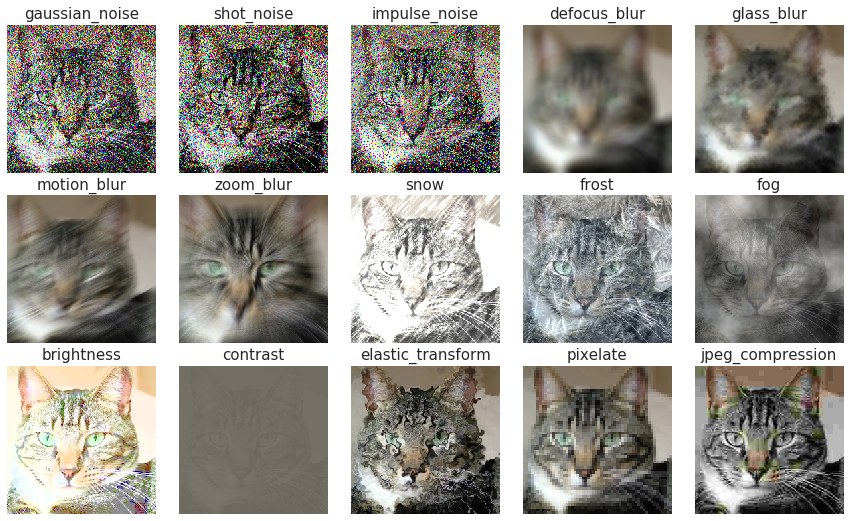

In [291]:
fig = plt.figure(figsize = (15.0, 9.0))

for i, img in enumerate(perturbed):
    plt.subplot(3,5,i+1)
    plt.imshow(img)      

    plt.title(corruptions[i], fontsize=fontsize)
    plt.axis('off')

sns.despine(trim=True, offset=5)
plt.subplots_adjust(wspace = 0.15, hspace = 0.15)

plt.show()
fig.savefig('../figures/corruption_preview.pdf', bbox_inches='tight')

In [377]:
examples = [perturbed[i] for i in [0, 3, 8, 11, 12]]
style_indices = [24, 10, 6, 1, 28]
styles = [Image.open(pbn_split.dataset.samples[pbn_split.indices[style]]) for style in style_indices]
stylized = [toPil(ast._transform(content_tensor.unsqueeze(0), (torch.tensor(1.), ast.style_features[style].unsqueeze(0))).squeeze()) for style in style_indices]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


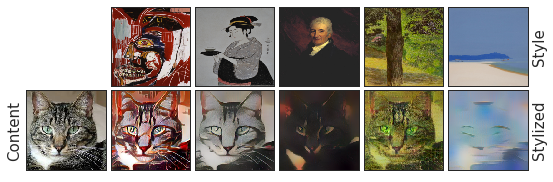

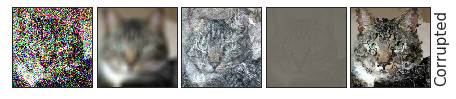

In [378]:
fig = plt.figure(figsize = (9, 3))
plt.subplot(2, 6, 7)
plt.imshow(content)
plt.xticks([])
plt.yticks([])
plt.ylabel('Content', fontsize=fontsize)

for i, (st, s) in enumerate(zip(stylized, styles)):
    plt.subplot(2, 6, 8+i)
    plt.imshow(st)
    
    plt.xticks([])
    plt.yticks([])
    if i == 4:
        ax = plt.gca()
        ax.yaxis.set_label_position("right")
        plt.ylabel('Stylized', fontsize=fontsize)
        
    plt.subplot(2, 6, 2+i)
    plt.imshow(toPil(S(s)))
    
    plt.xticks([])
    plt.yticks([])
    if i == 4:
        ax = plt.gca()
        ax.yaxis.set_label_position("right")
        plt.ylabel('Style', fontsize=fontsize)
        
plt.subplots_adjust(wspace = 0.05, hspace = 0.05)

plt.show()
fig.savefig('../figures/intro_teaser_0.pdf', bbox_inches='tight')

fig = plt.figure(figsize = (7.5, 1.5))
for i, corrupted in enumerate(examples):
    plt.subplot(1, 5, 1+i)
    plt.imshow(corrupted)
    plt.xticks([])
    plt.yticks([])
    if i == 4:
        ax = plt.gca()
        ax.yaxis.set_label_position("right")
        plt.ylabel('Corrupted', fontsize=fontsize)
    
plt.subplots_adjust(wspace = 0.05, hspace = 0.05)
plt.show()
fig.savefig('../figures/intro_teaser_1.pdf', bbox_inches='tight')       


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


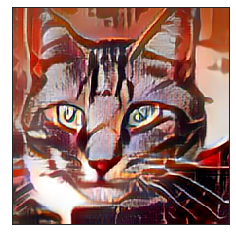

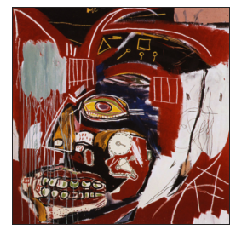

In [324]:
plt.figure()
plt.imshow(stylized[4])
plt.xticks([])
plt.yticks([])
plt.show()
plt.figure()
plt.imshow(toPil(S(styles[4])))
plt.xticks([])
plt.yticks([])
plt.show()